In [8]:
import pandas as pd
import re
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style("whitegrid")
import calendar

In [9]:
# First, let's import requisite files
orders      = pd.read_csv('../Instacart_Input/orders.csv')
prior_set   = pd.read_csv('../Instacart_Input/order_products__prior.csv')
train_set   = pd.read_csv('../Instacart_Input/order_products__train.csv')
aisles      = pd.read_csv('../Instacart_Input/aisles.csv')
departments = pd.read_csv('../Instacart_Input/departments.csv')
products    = pd.read_csv('../Instacart_Input/products.csv')

products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [10]:
# To avoid confusion down the road, I am changing the names of two aisles
# 'missing' and 'other', which share the same string values as their parent department 

aisles.loc[5,'aisle'] = 'other aisle'
aisles.loc[99,'aisle'] = 'missing aisle'
aisles.head(10)

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation
5,6,other aisle
6,7,packaged meat
7,8,bakery desserts
8,9,pasta sauce
9,10,kitchen supplies


In [11]:
# The aisles.csv and departments.csv files more useful when merged into the products.csv

# Departments appear to represent larger groups, with sub-groups represented by aisle, 
# not unlike a physical store. 

# Personally, I can more easily conceptualize this thusly:
# 'departments' == Categories, and 'aisles' == Sub-Categories.

# Merge Aisle and Department information into Product df

aisle_names              = aisles['aisle']
dept_names               = departments['department']
products['Category']     = dept_names[products
                                      ['department_id'].values-1].values
products['Sub_Category'] = dept_names[products
                                      ['department_id'
                                      ].values-1
                                     ].values + " >> " + aisle_names[products['aisle_id'
                                                                     ].values-1].values

cols = ['product_id',
        'product_name',
        'Category',
        'Sub_Category',
        'aisle_id',
        'department_id',
       ]
products = products[cols]


products.sort_values(by=['Category', 'Sub_Category']).head()

,product_id,product_name,Category,Sub_Category,aisle_id,department_id
349,350,Mixed 12 Pack Lion's Share Ale,alcohol,alcohol >> beers coolers,27,5
378,379,Super Dry Beer,alcohol,alcohol >> beers coolers,27,5
429,430,Born Yesterday Pale Ale,alcohol,alcohol >> beers coolers,27,5
469,470,Lite Beer,alcohol,alcohol >> beers coolers,27,5
735,736,"Beer, IPA",alcohol,alcohol >> beers coolers,27,5


In [12]:
# Example of missing category / aisle 
products[products['product_id'] == 6728]

,product_id,product_name,Category,Sub_Category,aisle_id,department_id
6727,6728,Fun Size Chocolate Candy,missing,missing >> missing aisle,100,21



### Things to note:

  * product_id seems to increase proportionally to with department_id | aisle_id (when sorted, low product_ids first, high product_ids last), which might be useful later


In [13]:
# Let's list the Category and Aisle counts, grouped alphabetically, arranged hierarchically.

data = {'Product_Count'     : products['Category'].value_counts(),
        '_Product_Count' : products['Sub_Category'].value_counts()
       }

counts_df = pd.DataFrame(data=data).fillna(value='--')
counts_df.index.names = ['Category']
counts_df.sort_index()

,Product_Count,_Product_Count
Category,,
alcohol,1054,--
alcohol >> beers coolers,--,385
alcohol >> red wines,--,232
alcohol >> specialty wines champagnes,--,95
alcohol >> spirits,--,195
alcohol >> white wines,--,147
babies,1081,--
babies >> baby accessories,--,44
babies >> baby bath body care,--,132


In [14]:
# products categorized as'missing' or 'other' account for 1,806 products,
# roughly 3.634% of the 49,688 total products. Not exactly negligible.

counts_df.sort_index()[99:103]

,Product_Count,_Product_Count
Category,,
missing,1258,--
missing >> missing aisle,--,1258
other,548,--
other >> other aisle,--,548


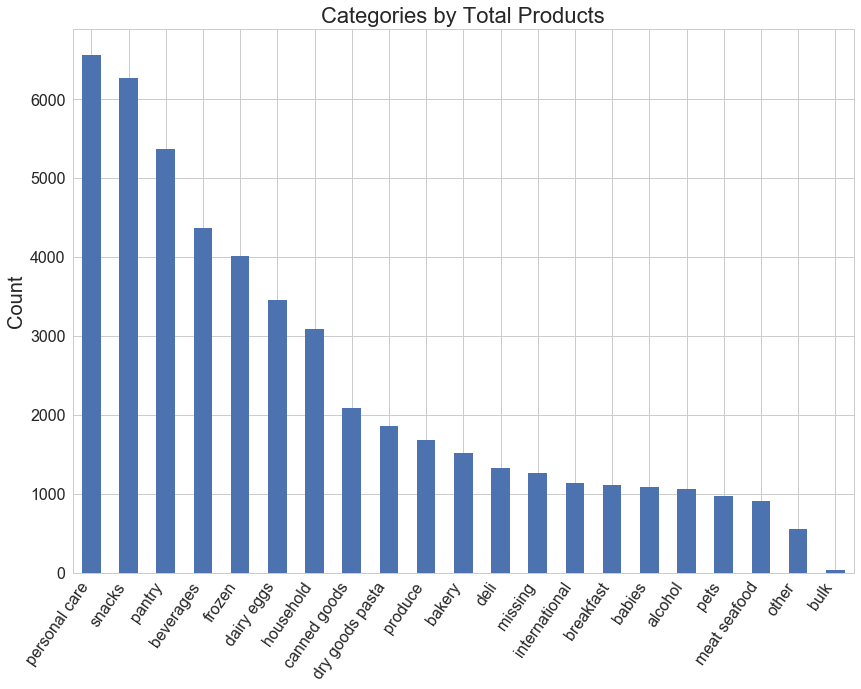

In [15]:
f, ax = plt.subplots(figsize=(14,10), ncols=1)

products['Category'].value_counts().plot(kind='bar')
_= ax.set_title('Categories by Total Products', size=22)
_= ax.set_ylabel('Count', size=20)
_= ax.tick_params(labelsize=16)
plt.xticks(ha='right', rotation=55);


In [16]:
# Let's plot sub-category (aisle) as a proportion of category (department)

#sns.barplot(x = stacked_bar_data.Group
#products.pivot('','')[].plot(kind='bar', stacked=True)

In [17]:
data1 = {'_Product_Count' : products['Sub_Category'].value_counts()
       }
data2 = {'Product_Count' : products['Category'].value_counts()
       }


d1_counts_df = pd.DataFrame(data=data1)
d2_counts_df = pd.DataFrame(data=data2)
data1['_Product_Count'].value_counts().sum()
d2_counts_df['Product_Count']['other']

548

In [18]:
data3 = { 'No. of Sub-Categories'       : {},
          'Products in Sub-Category'    : {},
          'Parent'                      : {},
          'Products in Parent Category' : {}
        }

for i in range(len(d1_counts_df['_Product_Count'])):
    #print counts_df.index[i], counts_df['_Product_Count'][i]
    match = re.findall(r'([\w ]+)( >> )([\w ]+)', d1_counts_df.index[i])
    parent, child = match[0][0], match[0][2]
    if parent in data3['No. of Sub-Categories']:
        data3['No. of Sub-Categories'][parent]       += 1
        data3['Products in Sub-Category'][child]      = d1_counts_df['_Product_Count'][i]
    else:
        data3['No. of Sub-Categories'][parent]               = 1
        data3['Products in Parent Category'][parent]  = d2_counts_df['Product_Count'][parent]
        data3['Products in Sub-Category'][child]      = d1_counts_df['_Product_Count'][i]
        
        
    if child not in data3['Parent']:
        data3['Parent'][child]                        = parent
        data3['Products in Parent Category'][child]   = d2_counts_df['Product_Count'][parent]


stacked_category_data = pd.DataFrame(data=data3)
stacked_category_data['Parent'
                     ] = stacked_category_data['Parent'
                                              ].fillna('None')
stacked_category_data['Products in Sub-Category'
                     ] = stacked_category_data['Products in Sub-Category'
                                              ].fillna('N/A')

stacked_category_data['No. of Sub-Categories'
                     ] = stacked_category_data['No. of Sub-Categories'
                                              ].fillna('None')

stacked_category_data.sort_values(by=['Parent', 'Products in Parent Category'])[21:40]

,No. of Sub-Categories,Parent,Products in Parent Category,Products in Sub-Category
beers coolers,None,alcohol,1054,385
red wines,None,alcohol,1054,232
specialty wines champagnes,None,alcohol,1054,95
spirits,None,alcohol,1054,195
white wines,None,alcohol,1054,147
baby accessories,None,babies,1081,44
baby bath body care,None,babies,1081,132
baby food formula,None,babies,1081,718
diapers wipes,None,babies,1081,187
bakery desserts,None,bakery,1516,297


In [19]:
# Let's plot Sub_Category product groups (aisle) 
# as a proportion of total products in Parent Category (department)


newstacked = stacked_category_data.groupby(['Parent', 
                                            stacked_category_data.index,
                                            'Products in Sub-Category'
                                           ]).size()[21:40]
newstacked

Parent                                 Products in Sub-Category
alcohol    beers coolers               385.0                       1
           red wines                   232.0                       1
           specialty wines champagnes  95.0                        1
           spirits                     195.0                       1
           white wines                 147.0                       1
babies     baby accessories            44.0                        1
           baby bath body care         132.0                       1
           baby food formula           718.0                       1
           diapers wipes               187.0                       1
bakery     bakery desserts             297.0                       1
           bread                       557.0                       1
           breakfast bakery            226.0                       1
           buns rolls                  195.0                       1
           tortillas flat bread        

In [20]:
aisles_only = stacked_category_data.sort_values(by=
                                                ['Parent',
                                                 'Products in Parent Category'])[21:]
Top15       = aisles_only.sort_values(by='Products in Sub-Category', 
                                      ascending=False)[:15]
Bottom15    = aisles_only.sort_values(by='Products in Sub-Category', 
                                      ascending=False)[119:]

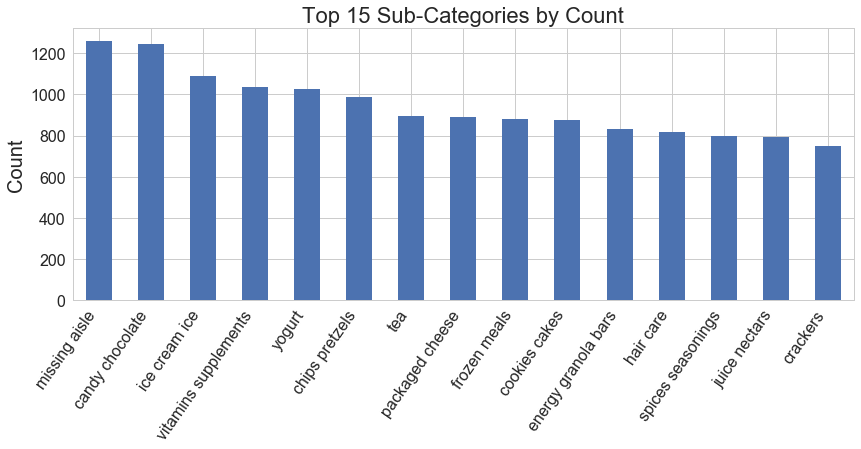

In [21]:
# Plotting top and Bottom 15 Sub-Categories by Product Count

f, ax = plt.subplots(figsize=(14,5))

Top15['Products in Sub-Category'].plot(kind='bar')
_= ax.set_title('Top 15 Sub-Categories by Count', size=22)
_= ax.set_ylabel('Count', size=20)
_= ax.tick_params(labelsize=16)
plt.xticks(ha='right', rotation=55);

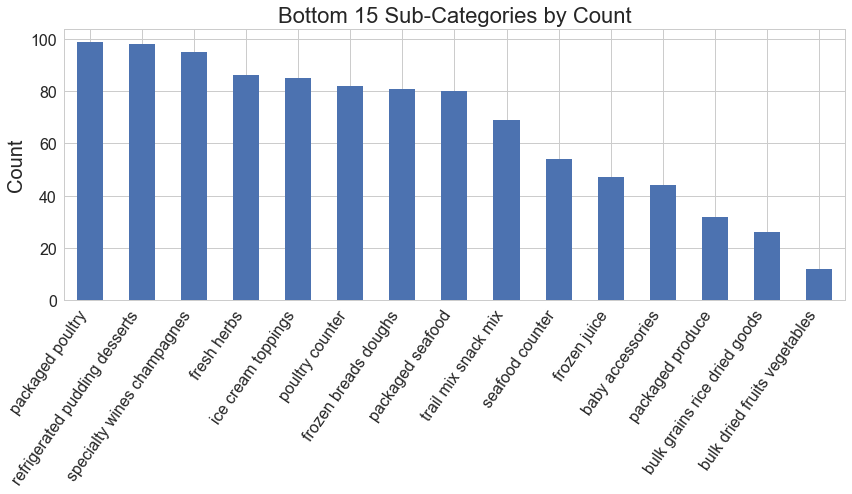

In [22]:
# Notice that the larger Sub-Categories reflect more vague grouping criteria, 
# e.g. "missing" isn't exactly specific
# which suggest less helpful groupings for making predictions
# as opposed to the smaller sub-categories below

f, ax = plt.subplots(figsize=(14,5))
Bottom15['Products in Sub-Category'].plot(kind='bar')
_= ax.set_title('Bottom 15 Sub-Categories by Count', size=22)
_= ax.set_ylabel('Count', size=20)
_= ax.tick_params(labelsize=16)
plt.xticks(ha='right', rotation=55);

In [93]:
# Now let's try to find some category trends. First, let's check out the alcohol category. 

master_set = pd.merge(pd.merge(prior_set, orders, on='order_id', how='right'), products,
                      on='product_id',
                      how='left')
master_set.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,Category,Sub_Category,aisle_id,department_id
0,2,33120,1.0,1.0,202279,prior,3,5,9,8.0,Organic Egg Whites,dairy eggs,dairy eggs >> eggs,86.0,16.0
1,2,28985,2.0,1.0,202279,prior,3,5,9,8.0,Michigan Organic Kale,produce,produce >> fresh vegetables,83.0,4.0
2,2,9327,3.0,0.0,202279,prior,3,5,9,8.0,Garlic Powder,pantry,pantry >> spices seasonings,104.0,13.0
3,2,45918,4.0,1.0,202279,prior,3,5,9,8.0,Coconut Butter,pantry,pantry >> oils vinegars,19.0,13.0
4,2,30035,5.0,0.0,202279,prior,3,5,9,8.0,Natural Sweetener,pantry,pantry >> baking ingredients,17.0,13.0


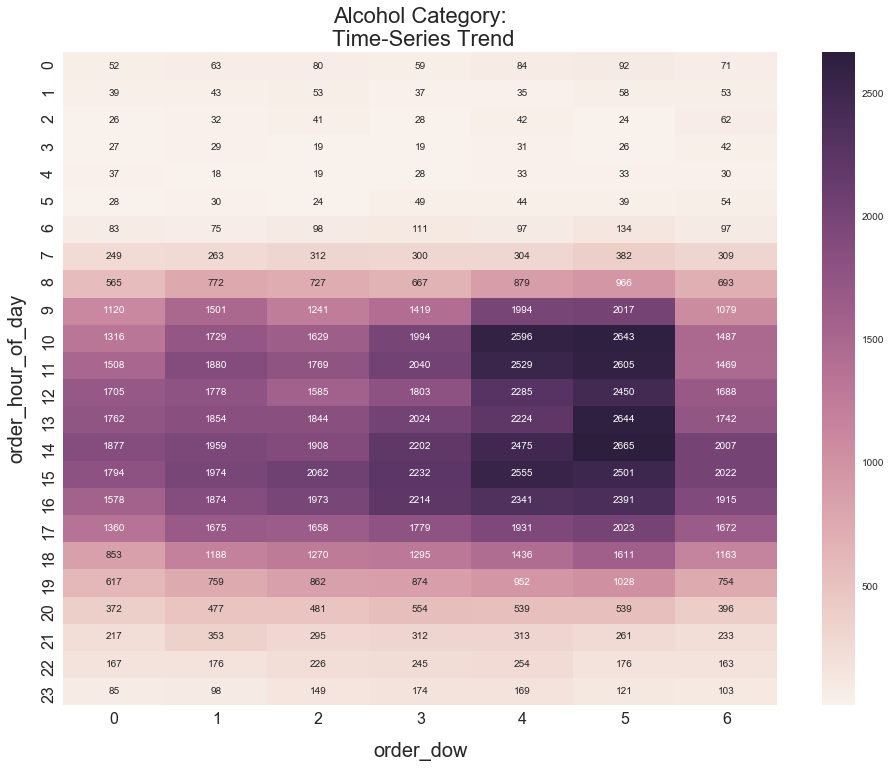

In [91]:
# Let's plot a heatmap of the count of products ordered in the alcohol category by hour and day

category_five = master_set[master_set['department_id'] == 5.0]
cat_heatmap_data = pd.DataFrame(category_five[['order_dow', 'order_hour_of_day']].groupby(['order_dow', 
                                                                                           'order_hour_of_day']
                                                                                         ).size()
                               ).reset_index()
cat_heatmap_data = cat_heatmap_data.pivot(index='order_hour_of_day', 
                                          columns='order_dow', 
                                          values=0)

f, ax = plt.subplots(figsize=(16,12))
_= ax.set_title('Alcohol Category:\n Time-Series Trend', size=22)
_= ax.set_ylabel('Hour of Day', size=20, labelpad=15)
_= ax.set_xlabel('Day of Week', size=20, labelpad=15)
_= ax.tick_params(labelsize=16)
sns.heatmap(cat_heatmap_data, ax=ax, annot=True, fmt="d");

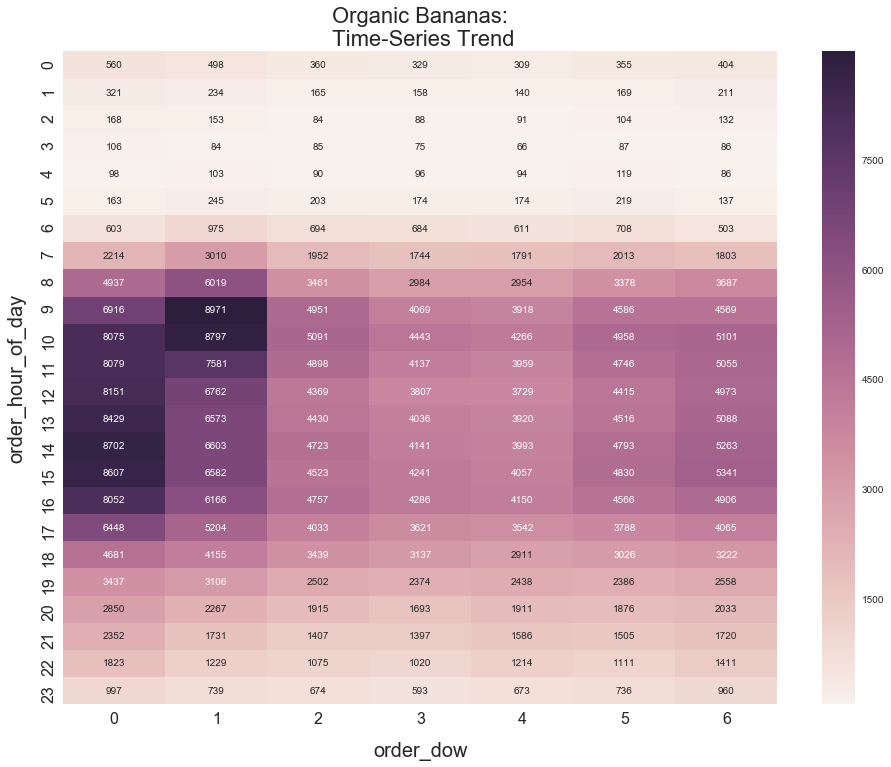

In [99]:
bananas = master_set[master_set['product_id'] == 24852]
cat_heatmap_data = pd.DataFrame(bananas[['order_dow', 'order_hour_of_day']].groupby(['order_dow', 
                                                                                           'order_hour_of_day']
                                                                                         ).size()
                               ).reset_index()
cat_heatmap_data = cat_heatmap_data.pivot(index='order_hour_of_day', 
                                          columns='order_dow', 
                                          values=0)

f, ax = plt.subplots(figsize=(16,12))
_= ax.set_title('Organic Bananas:\n Time-Series Trend', size=22)
_= ax.set_ylabel('Hour of Day', size=20, labelpad=15)
_= ax.set_xlabel('Day of Week', size=20, labelpad=15)
_= ax.tick_params(labelsize=16)
sns.heatmap(cat_heatmap_data, ax=ax, annot=True, fmt="d");